### Climate skill at 1&deg;

Annual- and global-mean time series and their R$^2$

In [1]:
from collections import namedtuple
from string import ascii_lowercase

import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

from utils import get_beaker_dataset_variables, savefig, DPI, FONTSIZE
from constants import INFERENCE_COMPARISON_1DEG

In [2]:
EvalVar = namedtuple("EvalVar", ("name", "long_name", "units"))

EVAL_VARS = [
    EvalVar("TMP2m", "2-meter air temperature", "K"),
    EvalVar("total_water_path", "total water path", "mm"),
]
ADDITIONAL_VARS = ['surface_temperature']
DS_VARS = [var.name for var in EVAL_VARS] + ADDITIONAL_VARS

In [3]:
def compute_r2(prediction: xr.DataArray, reference: xr.DataArray, dim: str='year'):
    reference_mean = reference.mean(dim=dim)
    ss_reference = ((reference - reference_mean) ** 2).sum(dim=dim)
    ss_error = ((prediction - reference) ** 2).sum(dim=dim)
    return 1 - (ss_error / ss_reference)

In [4]:
# download annual- and global-mean time series from beaker

datasets = []
for duration_name, duration_runs in INFERENCE_COMPARISON_1DEG.items():
    for group_name, group_runs in duration_runs.items():
        for ic_name, ic_run in group_runs.items():
            if "-" in ic_name:
                ic_name = ic_name.split("-")[1]
            full_key = '/'.join([duration_name, group_name, ic_name])
            print(f"Getting run: {full_key=}")
            ic_dataset = get_beaker_dataset_variables(ic_run, 'annual_diagnostics.nc', DS_VARS)
            dims = {'duration': [duration_name], 'group': [group_name], 'IC': [ic_name]}
            datasets.append(
                ic_dataset
                .expand_dims(**dims)
            )
annual_mean_ds = xr.merge(datasets).squeeze()
group_order = ['ACE2-ERA5', 'ACE2-SHiELD', 'ACE2-SHiELD-RS0', 'ACE2-SHiELD-RS1', 'ACE2-SHiELD-RS3', 'ACE-climSST', 'SHiELD-reference']
annual_mean_ds = annual_mean_ds.reindex(group=group_order)

Downloading ⠧ 0:00:00 1.8 MB/s 81.9 kB

In [5]:
r2_ds = compute_r2(
    annual_mean_ds.sel(source='prediction'),
    annual_mean_ds.sel(source='target')
)

In [6]:
# # download monthly data for forced SST time series from beaker
# !beaker dataset fetch "01J70F1FBDCR6WGNCYRD997JFB" --prefix "monthly_mean_target.nc" --output "./data/"

# compute forced SST time series excluding high latitudes
monthly_target = xr.open_dataset('./data/monthly_mean_target.nc', chunks={}, engine='h5netcdf').squeeze()
weights = np.cos(np.deg2rad(monthly_target.lat))
forced_sst = monthly_target.surface_temperature.where(monthly_target.ocean_fraction > 0.5).where(np.fabs(monthly_target.lat) < 45)
forced_sst_annual_mean = forced_sst.groupby(forced_sst.valid_time.dt.year).mean()
forced_sst_annual_global_mean = forced_sst_annual_mean.weighted(weights).mean(dim=['lat', 'lon']).compute()

In [7]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rc('font', size=FONTSIZE)
plt.rc('axes', titlesize=FONTSIZE)
plt.rc('axes', labelsize=(FONTSIZE - 2))
plt.rc('xtick', labelsize=(FONTSIZE - 2))
plt.rc('ytick', labelsize=(FONTSIZE - 2))
plt.rc('figure', dpi=DPI)

cmap_name = 'viridis_r'
n_colors_base = 5 # ACE2-ERA5, ACE2-SHiELD, SHiELD-reference, ACE-climSST, ERA5 vs SHiELD
i_color_repeat = 1
n_repeats = 4 # 4 ACE2-SHiELD seeds
base_color_scheme = plt.get_cmap(cmap_name)(np.linspace(0, 1, n_colors_base))
repeated_color = np.tile(base_color_scheme[i_color_repeat][None, :], (n_repeats - 1, 1))
color_scheme = np.insert(base_color_scheme, i_color_repeat, repeated_color, axis=0)

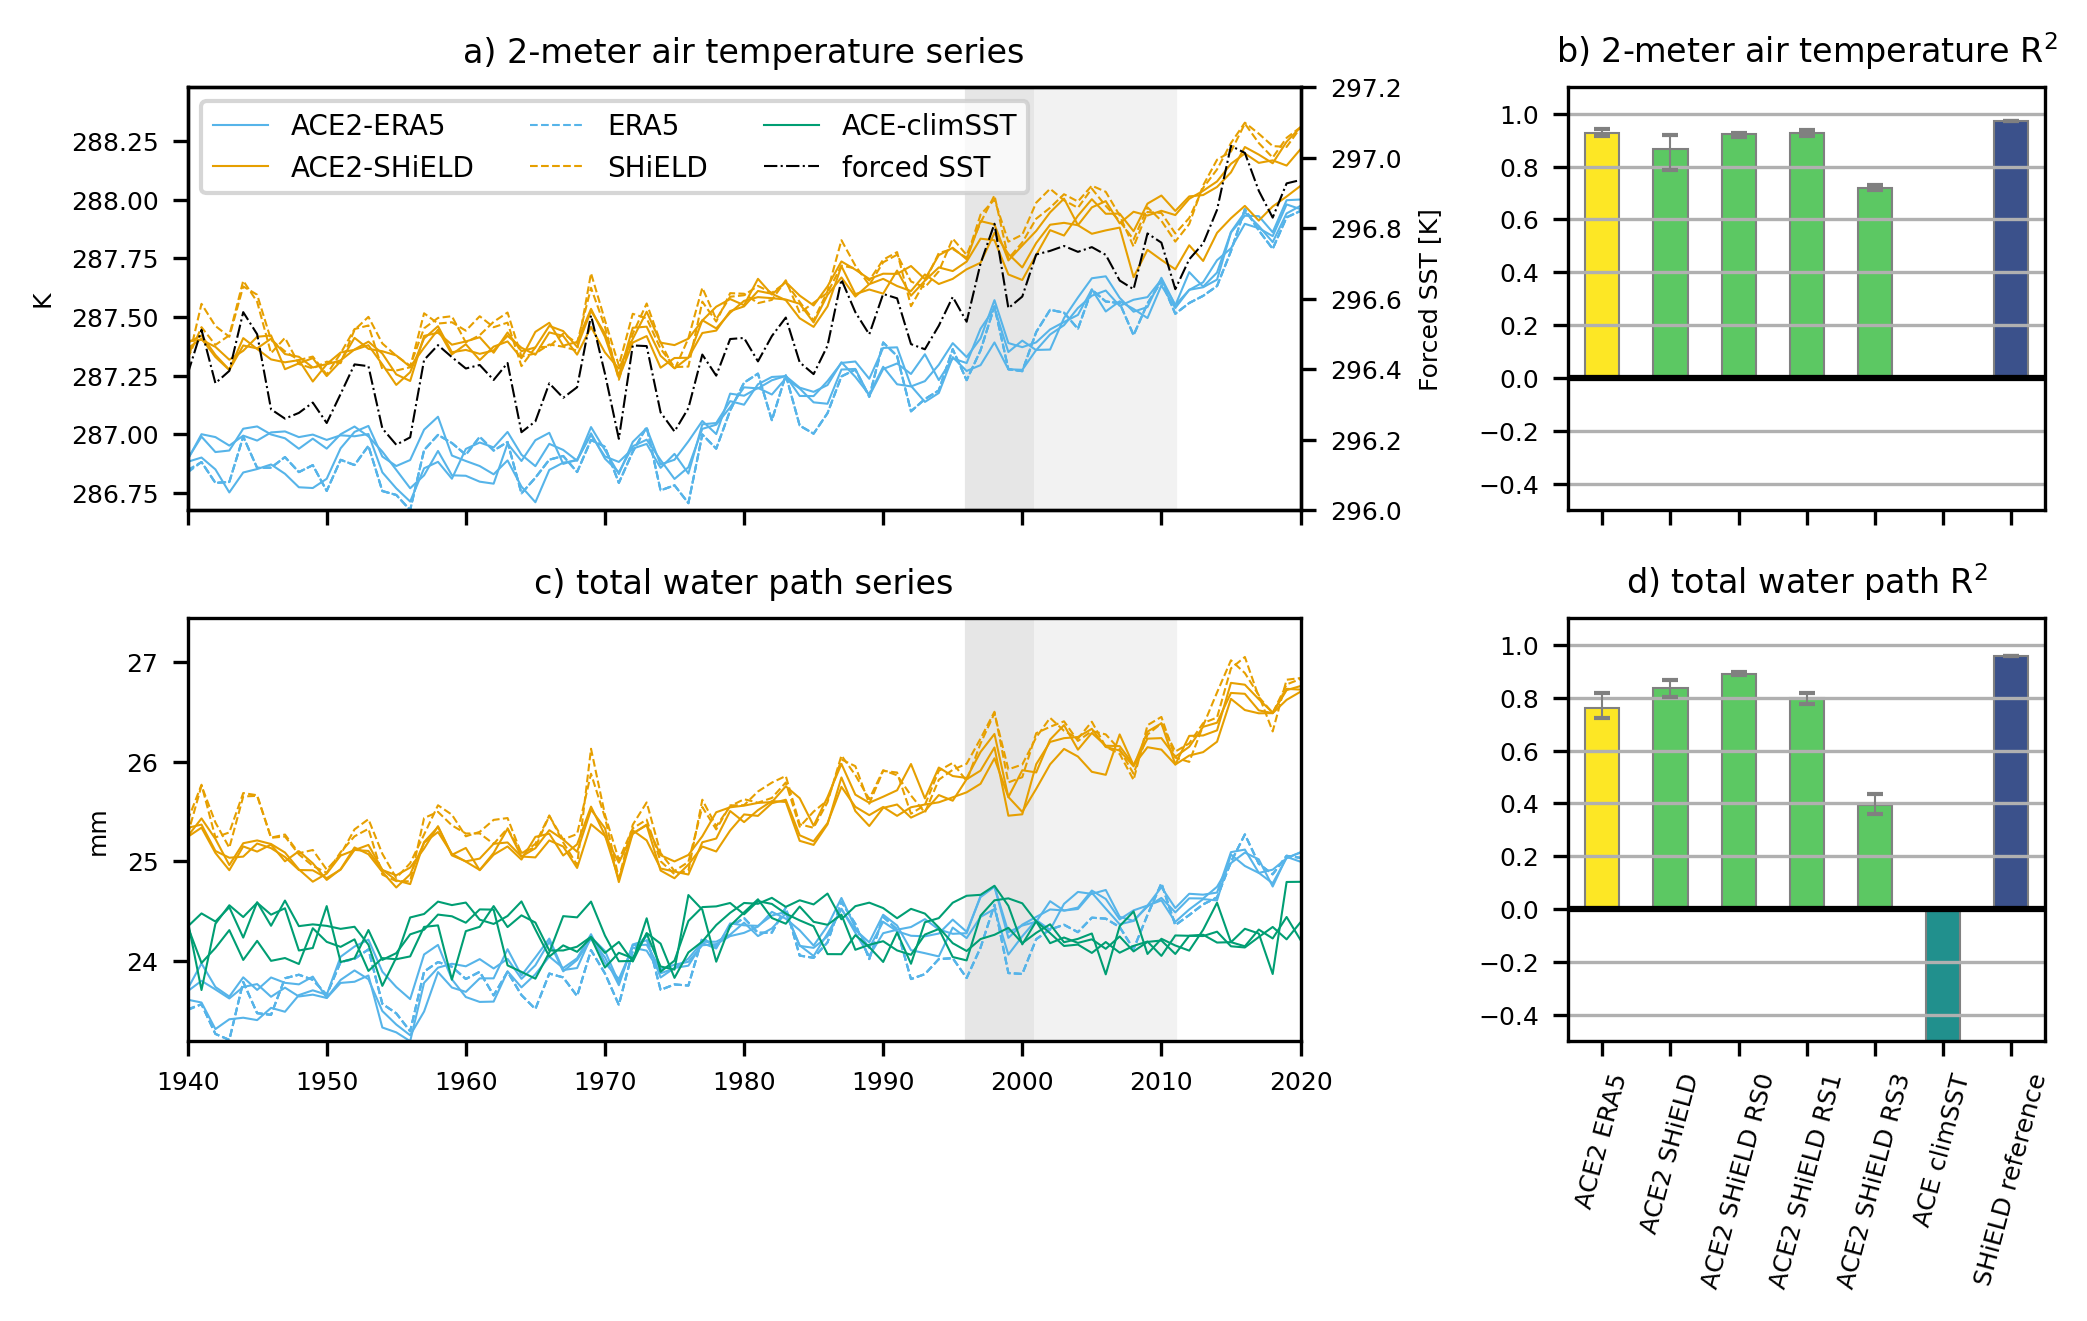

In [8]:
holdout_period1 = [1996, 2001]
fillcolor1 = [0.9, 0.9, 0.9]
holdout_period2 = [2001, 2011]
fillcolor2 = [0.95, 0.95, 0.95]
figsize = [1.27 * dim for dim in [5.5, 3.5]] # should be [5.5, 5.0], but need to scale up for unknown font size reasons

fig, axes = plt.subplots(2, len(EVAL_VARS), sharex='col', figsize=figsize, width_ratios=[0.7, 0.3])
for i, (ax_row, var) in enumerate(zip(axes, EVAL_VARS)):
    ax_series = ax_row[0]
    # highlight held-out periods
    ymin, ymax = annual_mean_ds[var.name].min(), annual_mean_ds[var.name].max()
    ax_series.fill_between(holdout_period1, [ymin, ymin], [ymax, ymax], color=fillcolor1)
    ax_series.fill_between(holdout_period2, [ymin, ymin], [ymax, ymax], color=fillcolor2)
    # time series
    he = annual_mean_ds.sel(source='target', duration='81yr', group='ACE2-ERA5')[var.name].plot(
        ax=ax_series, hue='IC', lw=0.5, color=colors[0], ls='--', add_legend=False
    )
    ha = annual_mean_ds.sel(source='prediction', duration='81yr', group='SHiELD-reference')[var.name].plot(
        ax=ax_series, hue='IC', lw=0.5, color=colors[1], ls='--', add_legend=False
    )
    annual_mean_ds.sel(source='target', duration='81yr', group='SHiELD-reference')[var.name].plot(
        ax=ax_series, hue='IC', lw=0.5, color=colors[1], ls='--', add_legend=False
    )
    hae = annual_mean_ds.sel(source='prediction', duration='81yr', group='ACE2-ERA5')[var.name].plot(
        ax=ax_series, hue='IC', lw=0.5, color=colors[0], add_legend=False
    )
    has = annual_mean_ds.sel(source='prediction', duration='81yr', group='ACE2-SHiELD')[var.name].plot(
        ax=ax_series, hue='IC', lw=0.5, color=colors[1], add_legend=False
    )
    hc = annual_mean_ds.sel(source='prediction', duration='81yr', group='ACE-climSST')[var.name].plot(
        ax=ax_series, hue='IC', lw=0.5, color=colors[2], add_legend=False
    )
    if var.name == 'TMP2m':
        ax_series2 = ax_series.twinx()
        hs = forced_sst_annual_global_mean.plot(ax=ax_series2, color='k', ls='-.', lw=0.5, label='forced SST', add_legend=False)
        ax_series2.set_ylabel('Forced SST [K]')
        ax_series2.set_ylim([296.0, 297.2])
        ax_series2.set_title(None)
        ax_series.legend(
            [hae[0], has[0], he[0], ha[0], hc[0], hs[0]],
            ['ACE2-ERA5', 'ACE2-SHiELD', 'ERA5', 'SHiELD', 'ACE-climSST', 'forced SST'],
            fontsize='small',
            ncols=3
        )
    ax_series.set_ylim([ymin, ymax])
    ax_series.set_xlim([1940, 2020])
    ax_series.set_ylabel(var.units)
    ax_series.set_xlabel(None)
    letter = ascii_lowercase[i * 2]
    ax_series.set_title(f"{letter}) {var.long_name} series")
    # R2 bar chart
    ax_r2 = ax_row[1]
    r2_da = r2_ds[var.name].sel(duration='81yr')
    mean = r2_da.mean('IC')
    ylower = (mean - r2_da.min('IC'))
    yupper = (r2_da.max('IC') - mean)
    yerr = np.vstack([ylower.to_numpy(), yupper.to_numpy()])
    ax_r2.plot([-1, len(mean)], [0, 0], 'k-')
    mean.to_series().plot.bar(
        ax=ax_r2,
        color=color_scheme,
        yerr=yerr,
        error_kw=dict(
            capsize=2,
            linewidth=0.5,
            ecolor='gray'),
        linewidth=0.5,
        edgecolor='gray',
        legend=False,
    )
    ax_r2.grid(axis='y')
    ax_r2.set_ylim([-0.5, 1.1])
    ax_r2.set_xlabel(None)
    ax_r2.set_xticklabels([groupname.item().replace('-', ' ') for groupname in mean.group], rotation=75)
    letter = ascii_lowercase[i * 2 + 1]
    ax_r2.set_title(
        f"{letter}) {var.long_name} "
        r"R$^2$"
    )
fig.tight_layout()
savefig(fig, 'climate_skill_1deg_annual_mean_series.png')